# Lagrange Interpolation

### Example 1: Lagrange interpolation over a 1D parameter space. 


Consider a model function that only depends on one uncertain parameter $q_1\in \mathbb{Q}_1$. 
The aim is to construct a 1D lagrange interpolation based on a limited number of samples drawn from $\mathbb{Q}_1$. 
`UQit` provide different methods for drawing samples for an uncertain parameter, and of course it can handle any arbitrary set of samples which are taken by the user. 

The model function is defied as, 
$$
\begin{equation}
r=10+0.7\sin(5q_1)+3 \cos(q_1)
\end{equation}
$$

Given values for $q_1$, the values of this function can be generated via `analyticTestFuncs.fEx1D(q1)`. 
to construct the Lagrange interpolation using the values of this simulator, we take the following steps:

**Step 1:** Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.getenv("UQit"))
import analyticTestFuncs
import sampling
import lagrangeInterpol
import reshaper

**Step 2:** Set the settings; We set the number of nodes (parameter samples), the admissbile space of the parameters $\mathbb{Q}_1$, how the samples are drawn, and number of test points in the parameter space to test the constructed Lagrange interpolation.

In [2]:
nNodes=10       #number of nodes
qBound=[-1,3]   #range over which nodes are randomly chosen
sampType='Clenshaw'  #how to generate nodes
                #'random', 'uniform', 'GL' (Gauss-Legendre), 'Clenshaw', 'Clenshaw-Curtis' 
nTest=100       #number of test points for plot    

**Step 3:** Draw samples for the parameters and run the simulator at each. 

In [3]:
qNodes=sampling.sampler_1d(qBound,nNodes,sampType)
fNodes=analyticTestFuncs.fEx1D(qNodes)

**Step 4:** Construct test values for the parameters at which the surrogate is tested. 

In [4]:
qTestFull=np.linspace(qBound[0],qBound[1],nTest)
qTest=np.linspace(min(qNodes),max(qNodes),nTest)

**Step 5:** Construct the Lagrange interpolation and evaluate it the test poins

In [5]:
fInterpTest=lagrangeInterpol.lagrangeInterpol_singleVar(fNodes,qNodes,qTest)

**Step 6** Plot and validation

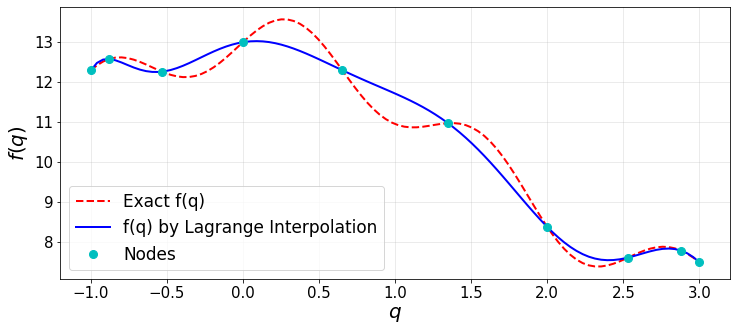

In [6]:
fTestFull=analyticTestFuncs.fEx1D(qTestFull)
plt.figure(figsize=(12,5))
plt.plot(qTestFull,fTestFull,'--r',lw=2,label='Exact f(q)')
plt.plot(qTest,fInterpTest,'-b',lw=2,label='f(q) by Lagrange Interpolation')
plt.plot(qNodes,fNodes,'oc',markersize='8',label='Nodes')
plt.legend(loc='best',fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.xlabel(r'$q$',fontsize=20)
plt.ylabel(r'$f(q)$',fontsize=20)
plt.show()

**Discussion** There are different factors that control the accuracy of the prediction of a Lagrange interplation. These include the number of nodes and the way they are generated. Try to rerun the above example adopting different values for `nNodes` and `sampType`.

### Example 2: Lagrange interpolation over a 2D parameter space. 
Consider a model function which depends on parameters $q_1\in \mathbb{Q}_1$ and $q_2\in\mathbb{Q}_2$. 
Consider the subspace $\mathbb{Q}^*_1\bigotimes\mathbb{Q}^*_2 \subset \mathbb{Q}_1\bigotimes\mathbb{Q}_2$. 
Through a few number of samples  $\mathbb{Q}^*_1\bigotimes\mathbb{Q}^*_2$, we want to reconstruct the response surface using Lagrange interpolation. 
The required steps are as in Example 1, with the additional step of constructing a 2D tensor-product grid using the samples of $q_1$ and $q_2$.

As the model response we consider
$$
\begin{eqnarray}
r=f(\mathbf{q}) &=& 3 \exp\left(-(q_2+2)^2-q_1^2\right)\left(q_1-1\right)^2 \\
                &-& \exp\left(-(q_1+2)^2-q_1^2\right)/3 \\
                &+& \exp\left(-(q_1^2+q_2^2)\right)\left(10q_1^3-2q_1+10q_2^5\right)\,,
\end{eqnarray}
$$

which is implemented in `UQit` in `analyticTestFuncs.fEx2D()` with keyword `type1`.

**Step 1:** Set the settings.

In [7]:
nNodes=[6,4]      #number of nodes in spaces of q1, q2
sampType=['GL',      #Method to draw samples for q1, q2 (see Example 1, Step 2)
          'uniform']
qBound=[[-0.75,1.5],  #spaces Q*1, Q*2
        [-0.5 ,2.5]]
domRange=[[-2,2], #spaces Q1, Q2
          [-3,3]]
nTest=[100,100] #number of test points for plotting

**Step 2:** Generate training data

In [8]:
p=len(nNodes)
qNodes=[]
for i in range(p):
    qNodes_=sampling.sampler_1d(qBound[i],nNodes[i],sampType[i])
    qNodes.append(qNodes_)
fNodes=analyticTestFuncs.fEx2D(qNodes[0],qNodes[1],'type1','tensorProd')

**Step 3:** Generate test samples over $\mathbb{Q}^*_1\bigotimes\mathbb{Q}^*_2$ at which the Lagrange interpolation is evaluated.

In [9]:
qTestList=[]
for i in range(p):
    qTest_ =np.linspace(qBound[i][0],qBound[i][1],nTest[i])  #test points in param_i space
    qTestList.append(qTest_)
qTest=reshaper.vecs2grid(qTestList[0],qTestList[1])

**Step 4:** Construct the Lagrange interpolation and evaluate it the test poins

In [10]:
fTest=lagrangeInterpol.lagrangeInterpol_multiVar(fNodes,qNodes,qTest,'tensorProd')

**Step 5:** Plot the original and interpolated response surfaces.

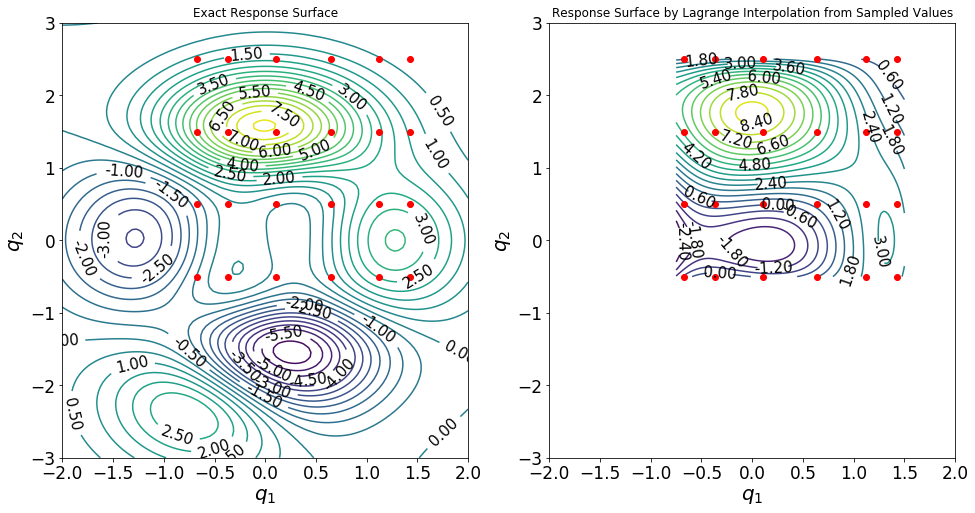

In [11]:
qTestFull=[]
for i in range(p):
    qTestFull_=np.linspace(domRange[i][0],domRange[i][1],nTest[i])  #test points in param1 space
    qTestFull.append(qTestFull_)

fTestFull=analyticTestFuncs.fEx2D(qTestFull[0],qTestFull[1],'type1','tensorProd')   #response value at the test points
fTestFullGrid=fTestFull.reshape((nTest[0],nTest[1]),order='F').T
fTestGrid=fTest.reshape((nTest[0],nTest[1]),order='F').T
plt.figure(figsize=(16,8));
plt.subplot(1,2,1)
ax=plt.gca()
CS1 = plt.contour(qTestFull[0],qTestFull[1],fTestFullGrid,35)#,cmap=plt.get_cmap('viridis'))
plt.clabel(CS1, inline=True, fontsize=15,colors='k',fmt='%0.2f',rightside_up=True,manual=False)
qNodesGrid=reshaper.vecs2grid(qNodes[0],qNodes[1])  #2d mesh 
plt.plot(qNodesGrid[:,0],qNodesGrid[:,1],'o',color='r',markersize=6)
plt.xlabel(r'$q_1$',fontsize=20);plt.ylabel(r'$q_2$',fontsize=20);
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Exact Response Surface')
plt.subplot(1,2,2)
ax=plt.gca()
CS2 = plt.contour(qTestList[0],qTestList[1],fTestGrid,20)#,cmap=plt.get_cmap('viridis'))
plt.clabel(CS2, inline=True, fontsize=15,colors='k',fmt='%0.2f',rightside_up=True,manual=False)
plt.plot(qNodesGrid[:,0],qNodesGrid[:,1],'o',color='r',markersize=6)
plt.xlabel('$q_1$',fontsize=20);plt.ylabel('$q_2$',fontsize=20);
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Response Surface by Lagrange Interpolation from Sampled Values')
plt.xlim(domRange[0])
plt.ylim(domRange[1])
plt.show()

**Discussion:** Try different types and numbers of training parameter samples!

### Example 3:  Lagrange interpolation over a 3D parameter space.

Consider the [Ishigami](https://inis.iaea.org/search/search.aspx?orig_q=RN:21024954) function,
$$
\begin{equation}
f(\mathbf{q}) = \sin(q_1)+a\sin^2(q_2)+b\,q_3^4\sin(q_1) \,.
\label{eq:ishigami}\tag{4}
\end{equation}
$$

where $q_i\in \mathbb{Q}_i\,,i=1,2,3$.
We want to find the error between the actual function values and what prediction by the Lagrange interpolation constructed based on a limited number of samples. 

**Step 1:** Set the settings

In [12]:
nNodes=[7,8,7] #number of Gauss quadratures in each of the 3 parameter spaces
sampType=['GL',      #Method to draw samples for q1, q2, q3
          'uniform',
          'Clenshaw']
qBound=[[-0.75,1.5], #1D parameter spaces
        [-0.5 ,2.5],
        [1,3]]
# Test points over each 1D parameter space
nTest=[8,6,7]
# Parameters in Ishigami function
a=0.2
b=0.1

**Step2 :** Generate the training data

In [13]:
p=len(nNodes)
qNodes=[]
for i in range(p):
    qNodes_=sampling.sampler_1d(qBound[i],nNodes[i],sampType[i])
    qNodes.append(qNodes_)
fNodes=analyticTestFuncs.fEx3D(qNodes[0],qNodes[1],qNodes[2],'Ishigami','tensorProd',{'a':a,'b':b})

**Step 3:** Generate test samples and exact response values. 

In [14]:
qTest=[]
for i in range(p):
    qTest_=np.linspace(qBound[i][0],qBound[i][1],nTest[i])
    qTest.append(qTest_)
fTestEx=analyticTestFuncs.fEx3D(qTest[0],qTest[1],qTest[2],'Ishigami','tensorProd',{'a':a,'b':b})
qTestGrid=reshaper.vecs2grid3d(qTest[0],qTest[1],qTest[2])

**Step 4:** Constract the Lagrange interpolation and evaluate it at the test samples. 

In [15]:
qTestGrid=reshaper.vecs2grid3d(qTest[0],qTest[1],qTest[2])
fInterp=lagrangeInterpol.lagrangeInterpol_multiVar(fNodes,qNodes,qTestGrid,'tensorProd')

**Step 5:** Plot 

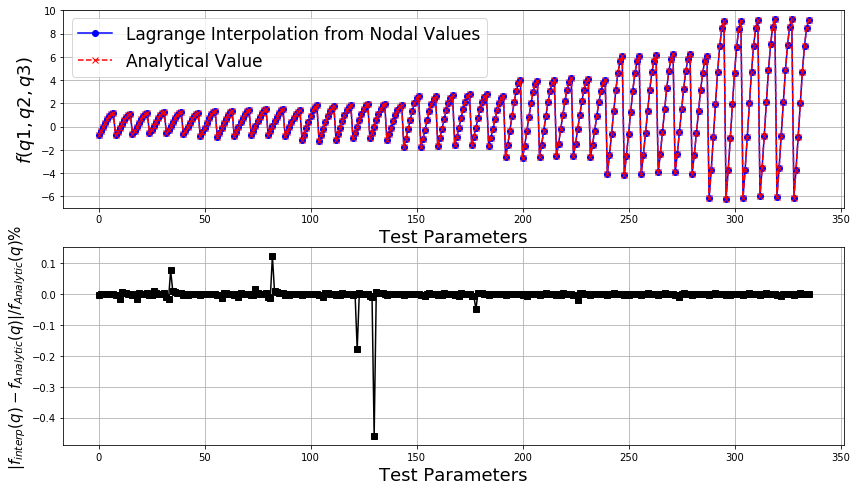

In [16]:
plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(fInterp,'-ob',label='Lagrange Interpolation from Nodal Values')
plt.plot(fTestEx,'--xr',label='Analytical Value')
plt.ylabel(r'$f(q1,q2,q3)$',fontsize=18)
plt.xlabel(r'Test Parameters',fontsize=18)
plt.legend(loc='best',fontsize=17)
plt.grid()
plt.subplot(2,1,2)
plt.plot(abs(fInterp-fTestEx)/(fTestEx)*100,'-sk')
plt.ylabel(r'$|f_{interp}(q)-f_{Analytic}(q)|/f_{Analytic}(q) \%$',fontsize=15)
plt.xlabel(r'Test Parameters',fontsize=18)
plt.grid()
plt.show()

Clearly, the error between the exact values of the Ishigami function and the values given by a Lagrange interpolation constructed from a limited number of samples in the parameter space is very small. One can investiagte how different number and type of training samples would influence the accuracy of the interpolation. 